In [233]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [235]:
from src.utils import *
from src.cleaning import *

In [236]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [237]:
df_riders = pd.read_csv("data/Riders.csv")
df_sample_submission = pd.read_csv("data/SampleSubmission.csv")
df_test = pd.read_csv("data/Test.csv")
df_train = pd.read_csv("data/Train.csv")
df_variable_definitions = pd.read_csv("data/VariableDefinitions.csv")

In [238]:
df_test['orders'] = df_test['Order No'].str.split('_').str[-1].astype(int)
df_train['orders'] = df_train['Order No'].str.split('_').str[-1].astype(int)

In [239]:
street_map = gpd.read_file('data/Division.shp',encoding="utf-8")

In [240]:
disjoint_cols = [
    "Arrival at Destination - Time",
    "Arrival at Destination - Weekday (Mo = 1)",
    "Arrival at Destination - Day of Month",
    "User Id",
    "Vehicle Type",
]

df = combine_train_test(df_train, df_test, df_riders, disjoint_cols).sort_values(by='orders')

In [241]:
df.columns

Index(['Arrival at Pickup - Day of Month', 'Arrival at Pickup - Time',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Confirmation - Day of Month',
       'Confirmation - Time', 'Confirmation - Weekday (Mo = 1)',
       'Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Personal or Business', 'Pickup - Day of Month', 'Pickup - Time',
       'Pickup - Weekday (Mo = 1)', 'Pickup Lat', 'Pickup Long',
       'Placement - Day of Month', 'Placement - Time',
       'Placement - Weekday (Mo = 1)', 'Platform Type',
       'Precipitation in millimeters', 'Rider Id', 'Temperature',
       'Time from Pickup to Arrival', 'User Id', 'Vehicle Type', 'col_type',
       'orders', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings'],
      dtype='object')

In [242]:
df.head(2)

,Arrival at Pickup - Day of Month,Arrival at Pickup - Time,Arrival at Pickup - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Time,Confirmation - Weekday (Mo = 1),Destination Lat,Destination Long,Distance (KM),Order No,...,Temperature,Time from Pickup to Arrival,User Id,Vehicle Type,col_type,orders,No_Of_Orders,Age,Average_Rating,No_of_Ratings
21987,26,2:18:16 PM,2,26,1:55:41 PM,2,-1.316539,36.706856,8,Order_No_0,...,31.0,NaN,User_Id_1085,Bike,test,0,292,349,15.0,39
6831,9,12:15:06 PM,2,9,12:12:24 PM,2,-1.265971,36.766806,4,Order_No_1,...,21.8,729.0,NaN,NaN,train,1,1043,771,14.1,76


In [243]:
geometry=gpd.points_from_xy(df['Pickup Long'], df['Pickup Lat'])

In [244]:
crs = {'init':'EPSG:21036'}

In [245]:
geo_df = gpd.GeoDataFrame(df,crs=crs,geometry=geometry)

In [246]:
BBox = (df['Pickup Long'].min(),   df['Destination Long'].max(),      
         df['Pickup Lat'].min(), df['Destination Lat'].max())

In [247]:
BBox

(36.653621, 37.0189577, -1.4383017, -1.0302254000000002)

In [248]:
img = plt.imread('data/Screen Shot 2019-11-07 at 4.44.58 PM.png')

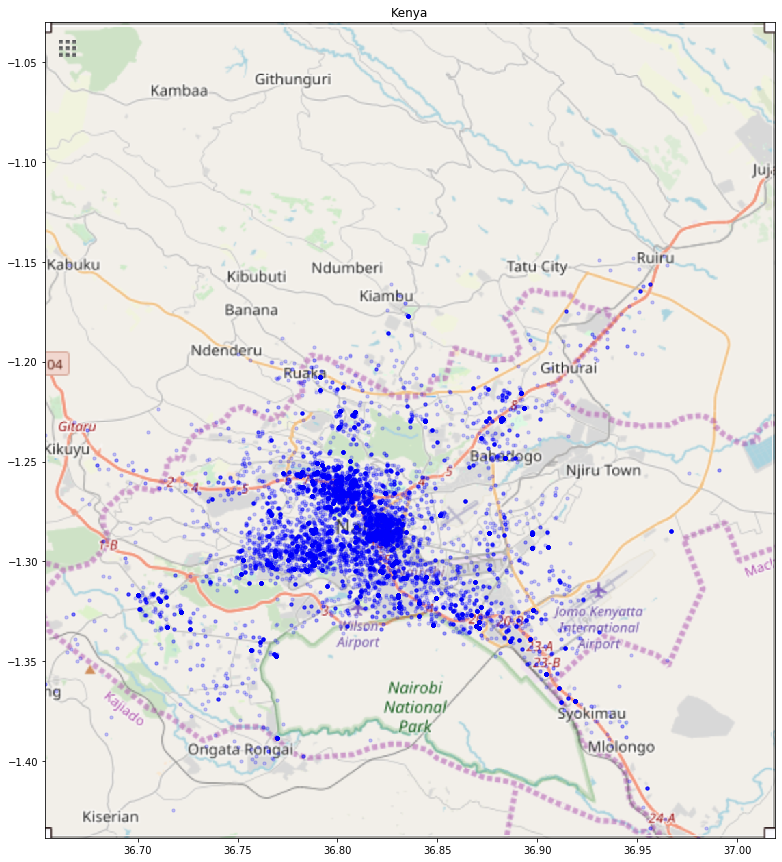

In [249]:
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(df['Pickup Long'], df['Pickup Lat'], zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Kenya')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(img, zorder=0, extent = BBox, aspect= 'equal')

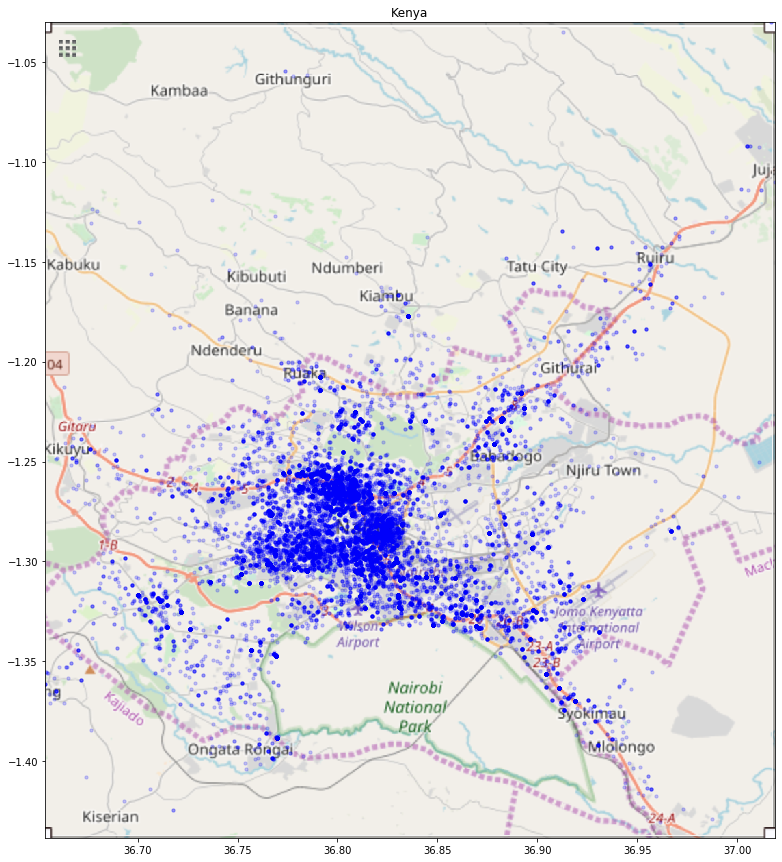

In [250]:
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(df['Destination Long'], df['Destination Lat'], zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Kenya')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(img, zorder=0, extent = BBox, aspect= 'equal')

In [251]:
def plot_on_map(df, BB, img, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,16))
    axs[0].scatter(df['Pickup Long'], df['Pickup Lat'], zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(img, zorder=0, extent=BB)

    axs[1].scatter(df['Destination Long'], df['Destination Lat'], zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(img, zorder=0, extent=BB)

In [252]:
BB = BBox

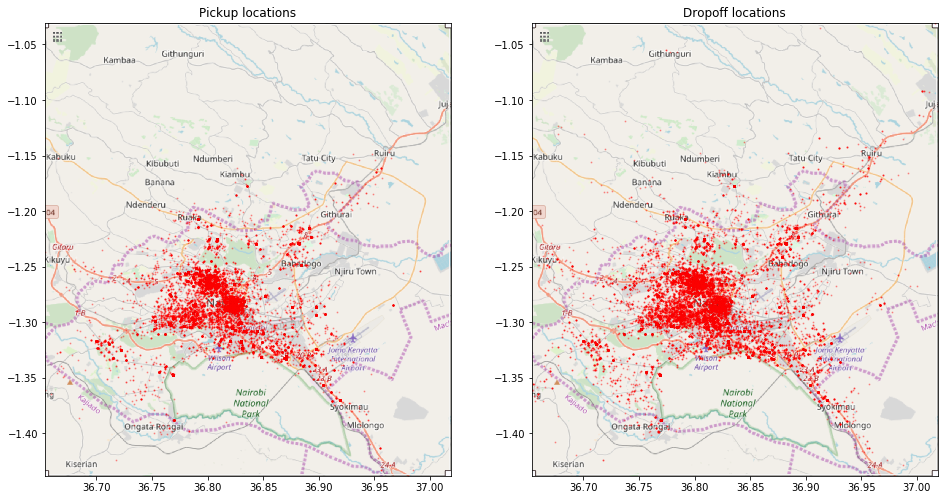

In [253]:
plot_on_map(df, BB, img, s=1, alpha=0.3)

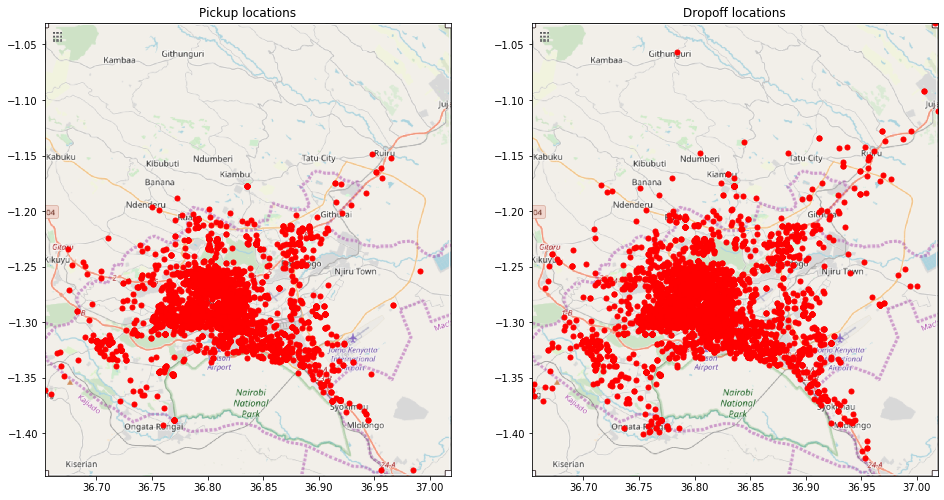

In [254]:
plot_on_map(df_test, BB, img, alpha=1.0, s=25)

In [255]:
df['pickup_longitude'] = df['Pickup Long']
df['pickup_latitude'] = df['Pickup Lat']
df['dropoff_longitude'] =df['Destination Long']
df['dropoff_latitude'] = df['Destination Lat']

In [256]:
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

In [257]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)


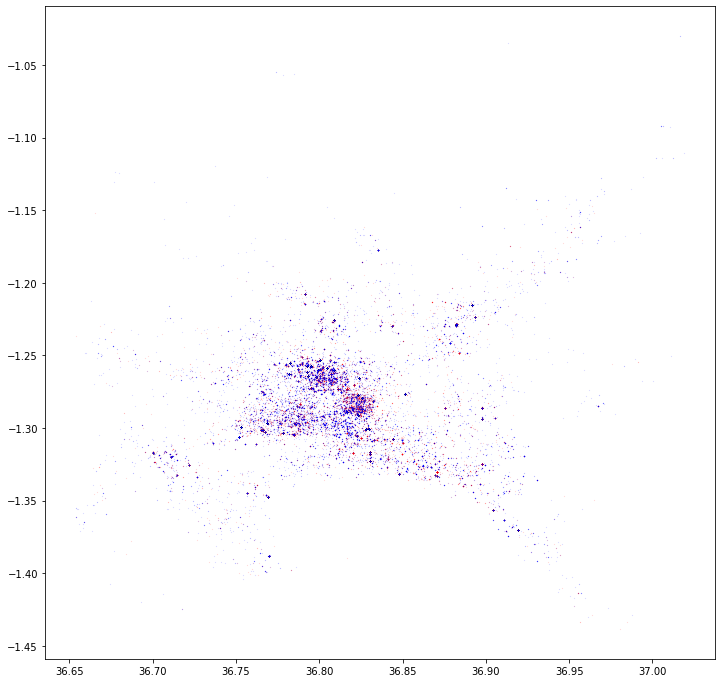

In [258]:
plot_hires(df,BB)

In [259]:
coords = np.vstack((df[['pickup_latitude', 'pickup_longitude']].values,
                    df[['dropoff_latitude', 'dropoff_longitude']].values,
                   ))

In [260]:
coords

array([[-1.301908  , 36.7592822 ],
       [-1.2741728 , 36.7969108 ],
       [-1.300921  , 36.828195  ],
       ...,
       [-1.289219  , 36.73749771],
       [-1.2413316 , 36.8785525 ],
       [-1.1605816 , 36.8977958 ]])

In [261]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

In [262]:
pca = PCA().fit(coords)
df['pickup_pca0'] = pca.transform(df[['pickup_latitude', 'pickup_longitude']])[:, 0]
df['pickup_pca1'] = pca.transform(df[['pickup_latitude', 'pickup_longitude']])[:, 1]
df['dropoff_pca0'] = pca.transform(df[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
df['dropoff_pca1'] = pca.transform(df[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [263]:
df['pickup_pca0']

21987    0.050133
6831     0.014934
720     -0.018461
18360    0.013954
694     -0.030729
           ...   
14908   -0.002685
27662    0.018187
10254    0.025617
7990     0.008379
6882     0.031165
Name: pickup_pca0, Length: 28269, dtype: float64

In [264]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [265]:
train = df.copy()
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

In [266]:
train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2

In [267]:
df = train.copy()

In [268]:
df.columns

Index(['Arrival at Pickup - Day of Month', 'Arrival at Pickup - Time',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Confirmation - Day of Month',
       'Confirmation - Time', 'Confirmation - Weekday (Mo = 1)',
       'Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Personal or Business', 'Pickup - Day of Month', 'Pickup - Time',
       'Pickup - Weekday (Mo = 1)', 'Pickup Lat', 'Pickup Long',
       'Placement - Day of Month', 'Placement - Time',
       'Placement - Weekday (Mo = 1)', 'Platform Type',
       'Precipitation in millimeters', 'Rider Id', 'Temperature',
       'Time from Pickup to Arrival', 'User Id', 'Vehicle Type', 'col_type',
       'orders', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings',
       'geometry', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan',
       'direction',

In [269]:
df_no_outlines = df[df['Time from Pickup to Arrival'] > 1]

In [270]:
df_no_outlines.shape,df.shape

((21164, 47), (28269, 47))

In [271]:
grp_rider = df_no_outlines.groupby('Rider Id')['Time from Pickup to Arrival','Distance (KM)'].mean()

In [272]:
grp_rider['rider_speed'] = (grp_rider['Distance (KM)'] * 1000)/grp_rider['Time from Pickup to Arrival'];grp_rider

,Time from Pickup to Arrival,Distance (KM),rider_speed
Rider Id,,,
Rider_Id_0,1393.000000,12.000000,8.614501
Rider_Id_1,1333.000000,11.000000,8.252063
Rider_Id_10,529.098039,9.490196,17.936555
Rider_Id_100,1271.929293,8.171717,6.424663
Rider_Id_101,1755.579235,10.491803,5.976263
...,...,...,...
Rider_Id_959,1556.086957,8.956522,5.755798
Rider_Id_96,1485.163462,9.817308,6.610254
Rider_Id_97,965.857143,10.571429,10.945126


In [273]:
df.head()

,Arrival at Pickup - Day of Month,Arrival at Pickup - Time,Arrival at Pickup - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Time,Confirmation - Weekday (Mo = 1),Destination Lat,Destination Long,Distance (KM),Order No,...,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,distance_haversine,distance_dummy_manhattan,direction,pca_manhattan,center_latitude,center_longitude
21987,26,2:18:16 PM,2,26,1:55:41 PM,2,-1.316539,36.706856,8,Order_No_0,...,0.050133,-0.024093,0.101165,-0.043022,6.050799,7.454893,-105.597778,0.069961,-1.309223,36.733069
6831,9,12:15:06 PM,2,9,12:12:24 PM,2,-1.265971,36.766806,4,Order_No_1,...,0.014934,0.006668,0.045616,0.012344,3.468717,4.258672,-74.756880,0.036358,-1.270072,36.781858
720,18,10:12:28 AM,4,18,10:09:50 AM,4,-1.388201,36.769945,16,Order_No_2,...,-0.018461,-0.017394,0.032350,-0.109204,11.667000,16.180562,-146.288835,0.142621,-1.344561,36.799070
18360,29,3:51:52 PM,3,29,3:16:26 PM,3,-1.283333,36.826008,4,Order_No_3,...,0.013954,0.020737,-0.014823,-0.000048,3.946620,5.564959,130.604541,0.049561,-1.271784,36.812532
694,12,3:18:55 PM,2,12,2:59:22 PM,2,-1.285565,36.824483,5,Order_No_4,...,-0.030729,-0.017061,-0.013488,-0.002399,2.516237,3.558480,-44.856291,0.031902,-1.293586,36.832466


In [274]:
df.columns

Index(['Arrival at Pickup - Day of Month', 'Arrival at Pickup - Time',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Confirmation - Day of Month',
       'Confirmation - Time', 'Confirmation - Weekday (Mo = 1)',
       'Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Personal or Business', 'Pickup - Day of Month', 'Pickup - Time',
       'Pickup - Weekday (Mo = 1)', 'Pickup Lat', 'Pickup Long',
       'Placement - Day of Month', 'Placement - Time',
       'Placement - Weekday (Mo = 1)', 'Platform Type',
       'Precipitation in millimeters', 'Rider Id', 'Temperature',
       'Time from Pickup to Arrival', 'User Id', 'Vehicle Type', 'col_type',
       'orders', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings',
       'geometry', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan',
       'direction',

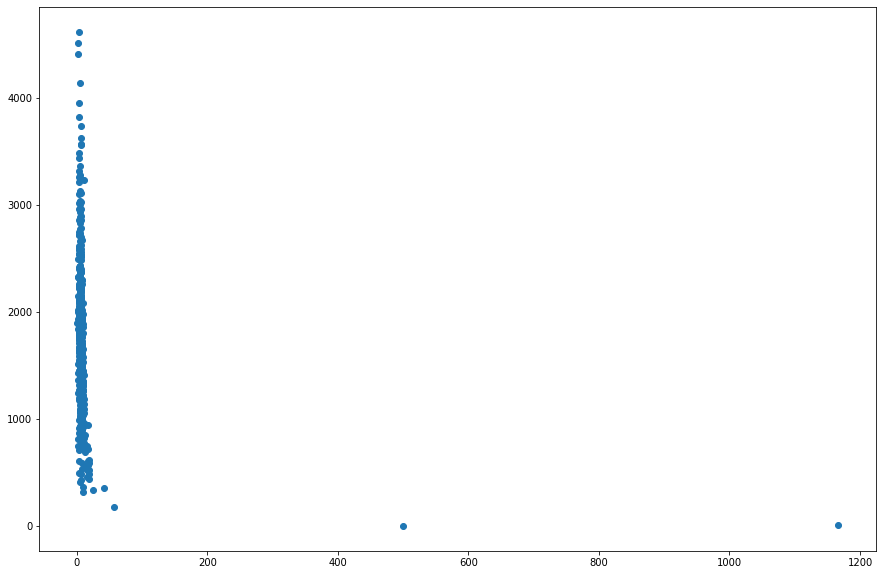

In [275]:
plt.scatter(x=grp_rider['rider_speed'],y=grp_rider['Time from Pickup to Arrival'])

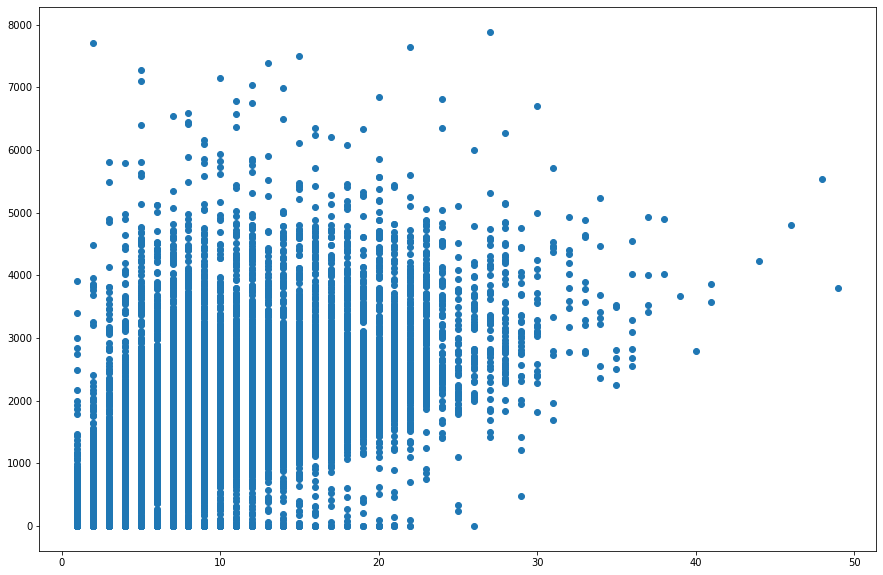

In [276]:
plt.scatter(x=df['Distance (KM)'],y=df['Time from Pickup to Arrival'])

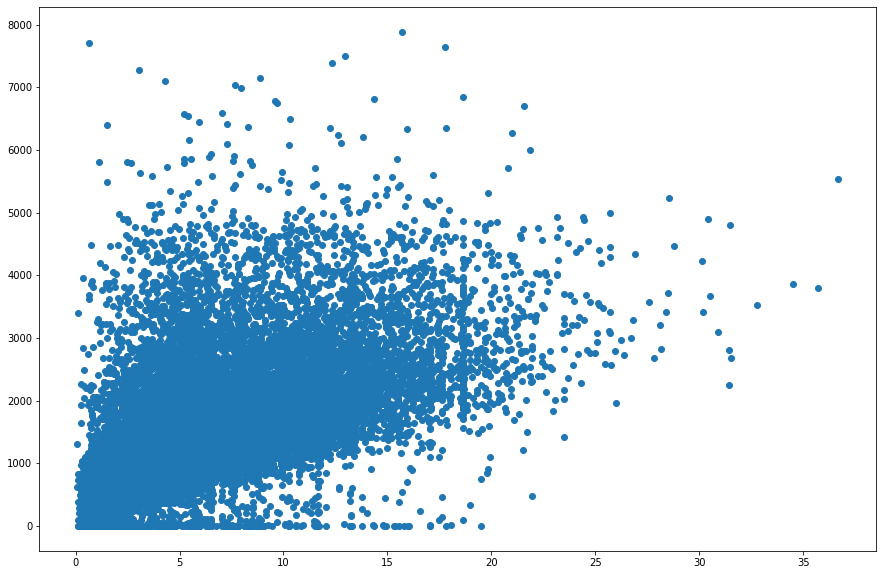

In [277]:
plt.scatter(x=df['distance_haversine'],y=df['Time from Pickup to Arrival'])

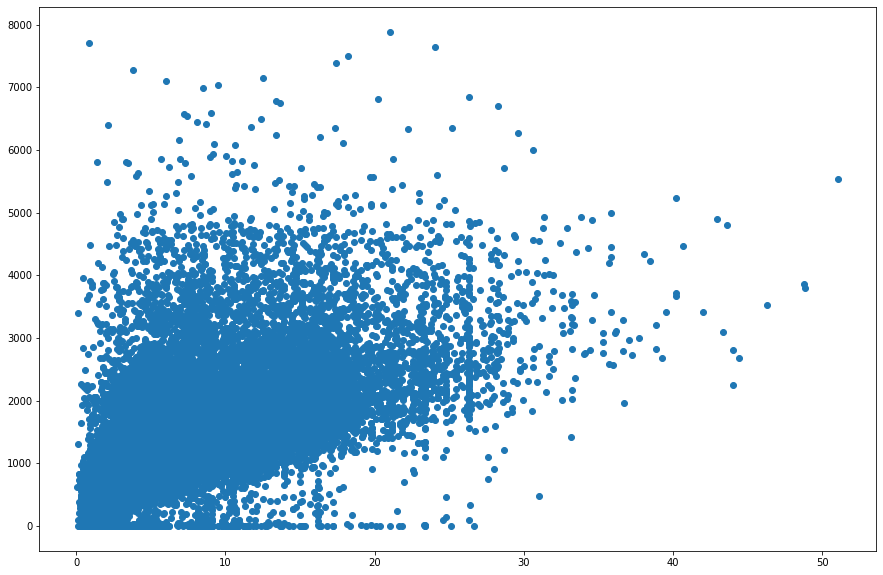

In [278]:
plt.scatter(x=df['distance_dummy_manhattan'],y=df['Time from Pickup to Arrival'])

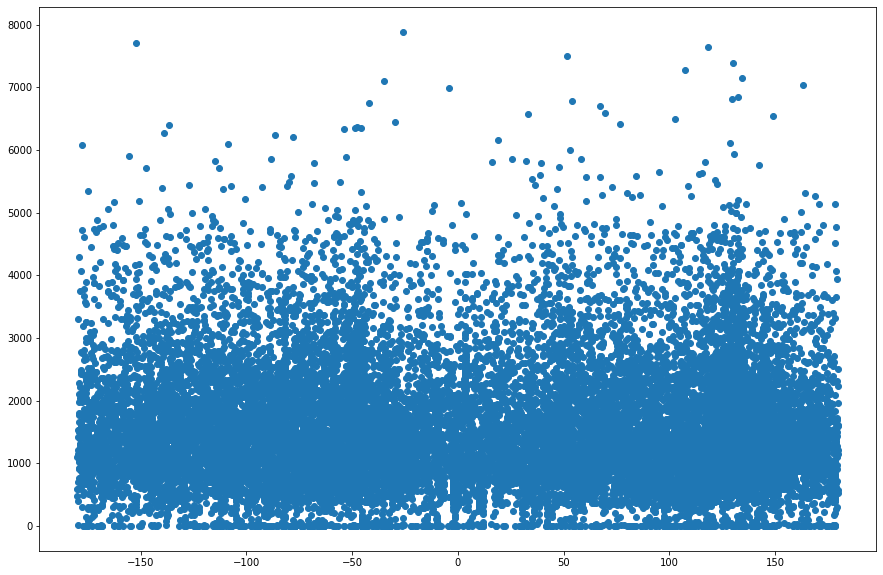

In [279]:
plt.scatter(x=df['direction'],y=df['Time from Pickup to Arrival'])

In [280]:
display_all(df.head())

,Arrival at Pickup - Day of Month,Arrival at Pickup - Time,Arrival at Pickup - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Time,Confirmation - Weekday (Mo = 1),Destination Lat,Destination Long,Distance (KM),Order No,Personal or Business,Pickup - Day of Month,Pickup - Time,Pickup - Weekday (Mo = 1),Pickup Lat,Pickup Long,Placement - Day of Month,Placement - Time,Placement - Weekday (Mo = 1),Platform Type,Precipitation in millimeters,Rider Id,Temperature,Time from Pickup to Arrival,User Id,Vehicle Type,col_type,orders,No_Of_Orders,Age,Average_Rating,No_of_Ratings,geometry,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,distance_haversine,distance_dummy_manhattan,direction,pca_manhattan,center_latitude,center_longitude
21987,26,2:18:16 PM,2,26,1:55:41 PM,2,-1.316539,36.706856,8,Order_No_0,Business,26,2:20:40 PM,2,-1.301908,36.759282,26,1:47:47 PM,2,3,NaN,Rider_Id_678,31.0,NaN,User_Id_1085,Bike,test,0,292,349,15.0,39,POINT (36.75928 -1.30191),36.759282,-1.301908,36.706856,-1.316539,0.050133,-0.024093,0.101165,-0.043022,6.050799,7.454893,-105.597778,0.069961,-1.309223,36.733069
6831,9,12:15:06 PM,2,9,12:12:24 PM,2,-1.265971,36.766806,4,Order_No_1,Personal,9,12:20:43 PM,2,-1.274173,36.796911,9,12:10:50 PM,2,1,NaN,Rider_Id_848,21.8,729.0,NaN,NaN,train,1,1043,771,14.1,76,POINT (36.79691 -1.27417),36.796911,-1.274173,36.766806,-1.265971,0.014934,0.006668,0.045616,0.012344,3.468717,4.258672,-74.756880,0.036358,-1.270072,36.781858
720,18,10:12:28 AM,4,18,10:09:50 AM,4,-1.388201,36.769945,16,Order_No_2,Business,18,10:51:52 AM,4,-1.300921,36.828195,18,10:09:10 AM,4,3,NaN,Rider_Id_148,NaN,1923.0,NaN,NaN,train,2,4671,941,14.1,973,POINT (36.82820 -1.30092),36.828195,-1.300921,36.769945,-1.388201,-0.018461,-0.017394,0.032350,-0.109204,11.667000,16.180562,-146.288835,0.142621,-1.344561,36.799070
18360,29,3:51:52 PM,3,29,3:16:26 PM,3,-1.283333,36.826008,4,Order_No_3,Business,29,3:53:37 PM,3,-1.260234,36.799055,29,3:00:12 PM,3,3,NaN,Rider_Id_393,20.9,2186.0,NaN,NaN,train,3,3427,2385,14.2,1010,POINT (36.79905 -1.26023),36.799055,-1.260234,36.826008,-1.283333,0.013954,0.020737,-0.014823,-0.000048,3.946620,5.564959,130.604541,0.049561,-1.271784,36.812532
694,12,3:18:55 PM,2,12,2:59:22 PM,2,-1.285565,36.824483,5,Order_No_4,Personal,12,3:52:51 PM,2,-1.301607,36.840449,12,2:58:52 PM,2,3,NaN,Rider_Id_181,NaN,1688.0,NaN,NaN,train,4,34,291,15.0,5,POINT (36.84045 -1.30161),36.840449,-1.301607,36.824483,-1.285565,-0.030729,-0.017061,-0.013488,-0.002399,2.516237,3.558480,-44.856291,0.031902,-1.293586,36.832466


### Orders per day

In [281]:
opd = df[['Time from Pickup to Arrival','Confirmation - Day of Month','Confirmation - Time','Confirmation - Weekday (Mo = 1)','Pickup - Day of Month','Pickup - Time','Pickup - Weekday (Mo = 1)','orders']]

In [282]:
opd.head()

,Time from Pickup to Arrival,Confirmation - Day of Month,Confirmation - Time,Confirmation - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Time,Pickup - Weekday (Mo = 1),orders
21987,NaN,26,1:55:41 PM,2,26,2:20:40 PM,2,0
6831,729.0,9,12:12:24 PM,2,9,12:20:43 PM,2,1
720,1923.0,18,10:09:50 AM,4,18,10:51:52 AM,4,2
18360,2186.0,29,3:16:26 PM,3,29,3:53:37 PM,3,3
694,1688.0,12,2:59:22 PM,2,12,3:52:51 PM,2,4


In [283]:
opd.groupby('Pickup - Day of Month')['Pickup - Day of Month'].count()

Pickup - Day of Month
1      650
2      805
3      973
4     1023
5     1009
6     1017
7     1115
8     1126
9      874
10     922
11    1022
12     915
13    1093
14    1025
15     993
16     761
17     808
18    1008
19     816
20     865
21     879
22     859
23     776
24     802
25     910
26     846
27     885
28    1039
29     923
30     944
31     586
Name: Pickup - Day of Month, dtype: int64

#### How many packages does a biker carry?

In [284]:
df['Pickup - Time'] = pd.to_datetime(df['Pickup - Time'])
df['pickup_hour'] = df['Pickup - Time'].apply(lambda x: x.hour)

In [285]:
df.groupby(['Rider Id'])['Pickup - Day of Month'].count()

Rider Id
Rider_Id_0        1
Rider_Id_1        1
Rider_Id_10      62
Rider_Id_100    129
Rider_Id_101    262
               ... 
Rider_Id_959     31
Rider_Id_96     137
Rider_Id_97       8
Rider_Id_98       4
Rider_Id_99      73
Name: Pickup - Day of Month, Length: 952, dtype: int64

In [286]:
df.groupby(['Rider Id'])['pickup_hour'].count()

Rider Id
Rider_Id_0        1
Rider_Id_1        1
Rider_Id_10      62
Rider_Id_100    129
Rider_Id_101    262
               ... 
Rider_Id_959     31
Rider_Id_96     137
Rider_Id_97       8
Rider_Id_98       4
Rider_Id_99      73
Name: pickup_hour, Length: 952, dtype: int64

In [287]:
df['pickup_hour'].value_counts()

15    3654
12    3617
11    3599
13    3327
10    3272
14    3239
16    2815
9     2145
17    1289
8      532
18     428
19     199
20      72
7       42
21      32
22       4
23       2
0        1
Name: pickup_hour, dtype: int64

In [288]:
df.groupby(['Pickup - Day of Month','Pickup - Weekday (Mo = 1)'])['pickup_hour','Pickup - Weekday (Mo = 1)'].count()

pickup_hour  \
Pickup - Day of Month Pickup - Weekday (Mo = 1)                
1                     1                                  208   
                      2                                    8   
                      3                                   85   
                      4                                  123   
                      5                                  184   
...                                                      ...   
31                    2                                   81   
                      3                                  121   
                      4                                  171   
                      5                                  166   
                      7                                    2   

                                                 Pickup - Weekday (Mo = 1)  
Pickup - Day of Month Pickup - Weekday (Mo = 1)                             
1                     1                                                208  
                      2                                                  8  
                      3                                                 85  
                      4                                                123  
                      5                                                184  
...                                                                    ...  
31                    2                                                 81  
                      3                                                121  
                      4                                                171  
                      5                                                166  
                      7                                                  2  

[216 rows x 2 columns]

#### Get all pickup points

In [289]:
df['Pickup Lat'].nunique(),df['Pickup Long'].nunique()

(4393, 4377)

In [290]:
opp = df.groupby(['Pickup Lat','Pickup Long'])['orders'].count()

In [291]:
opp.nlargest(10)

Pickup Lat  Pickup Long
-1.255189   36.782203      3231
-1.257147   36.795063       852
-1.316711   36.830156       787
-1.300921   36.828195       707
-1.300406   36.829741       678
-1.258414   36.804800       534
-1.272639   36.794723       381
-1.290894   36.822971       349
-1.279395   36.825364       297
-1.273056   36.811298       265
Name: orders, dtype: int64

In [292]:
opp.sum()

28269

#### Riders coming to pickup point

In [293]:
rpp = df.groupby(['Pickup Lat','Pickup Long'])['Rider Id'].count();rpp

Pickup Lat  Pickup Long
-1.438302   36.980691      1
-1.433512   36.984545      1
-1.433256   36.956299      2
-1.428932   36.963932      1
-1.424204   36.717817      1
                          ..
-1.151811   36.665451      1
-1.151797   36.964747      1
-1.149010   36.930741      1
-1.148352   36.948018      1
-1.147170   36.963604      1
Name: Rider Id, Length: 4430, dtype: int64

### Destination 

In [294]:
rdd = df.groupby(['Destination Lat','Destination Long'])['orders'].count();rdd

Destination Lat  Destination Long
-1.430298        36.961368           1
-1.428762        36.987545           1
-1.424204        36.717817           2
-1.423840        36.973006           1
-1.422652        36.953083           1
                                    ..
-1.056848        36.777982           1
-1.056342        36.784636           1
-1.054634        36.773911           2
-1.035262        36.913132           1
-1.030225        37.016779           2
Name: orders, Length: 6311, dtype: int64

In [295]:
rdd.nlargest(20)

Destination Lat  Destination Long
-1.300406        36.829741           757
-1.255189        36.782203           733
-1.263818        36.793006           403
-1.265715        36.823815           361
-1.262847        36.781805           355
-1.257147        36.795063           350
-1.260093        36.808869           345
-1.306378        36.751984           287
-1.258414        36.804800           279
-1.299144        36.752880           278
-1.290894        36.822971           264
-1.279395        36.825364           242
-1.257422        36.792707           232
-1.252796        36.800313           232
-1.288780        36.816831           228
-1.296310        36.768822           227
-1.277071        36.823109           222
-1.300921        36.828195           207
-1.228911        36.881876           183
-1.276574        36.851365           171
Name: orders, dtype: int64

#### Pickup destination pair

In [188]:
pdd = df.groupby(['Pickup Lat','Pickup Long','Destination Lat','Destination Long'])['orders'].count();pdd

Pickup Lat  Pickup Long  Destination Lat  Destination Long
-1.438302   36.980691    -1.269766        36.759586           1
-1.433512   36.984545    -1.275786        36.806355           1
-1.433256   36.956299    -1.300921        36.828195           1
                         -1.260234        36.799055           1
-1.428932   36.963932    -1.319281        36.712189           1
                                                             ..
-1.151811   36.665451    -1.300921        36.828195           1
-1.151797   36.964747    -1.294555        36.839750           1
-1.149010   36.930741    -1.215601        36.891686           1
-1.148352   36.948018    -1.280912        36.785252           1
-1.147170   36.963604    -1.288617        36.783680           1
Name: orders, Length: 16465, dtype: int64

In [189]:
pdd.nlargest(20)

Pickup Lat  Pickup Long  Destination Lat  Destination Long
-1.316711   36.830156    -1.300406        36.829741           246
-1.300406   36.829741    -1.263818        36.793006           143
-1.316711   36.830156    -1.306378        36.751984           126
-1.307787   36.844321    -1.300406        36.829741           124
-1.316711   36.830156    -1.263818        36.793006           118
-1.317755   36.830370    -1.306378        36.751984           115
-1.300921   36.828195    -1.388201        36.769945           108
-1.300406   36.829741    -1.277071        36.823109            96
-1.263818   36.793006    -1.300406        36.829741            91
-1.258414   36.804800    -1.255189        36.782203            90
-1.260093   36.808869    -1.262847        36.781805            82
                         -1.265715        36.823815            80
-1.300921   36.828195    -1.177202        36.835118            79
                         -1.319862        36.711032            75
-1.316711   36.83

In [224]:
pdd = pdd.reset_index()

In [298]:
pdd = pdd.rename({"orders":"pickup_destination_traffic"},axis=1)

In [299]:
pdd.nlargest(10,columns="pickup_destination_traffic")

,Pickup Lat,Pickup Long,Destination Lat,Destination Long,pickup_destination_traffic
2097,-1.316711,36.830156,-1.300406,36.829741,246
4192,-1.300406,36.829741,-1.263818,36.793006,143
2095,-1.316711,36.830156,-1.306378,36.751984,126
2700,-1.307787,36.844321,-1.300406,36.829741,124
2104,-1.316711,36.830156,-1.263818,36.793006,118
1901,-1.317755,36.830370,-1.306378,36.751984,115
3763,-1.300921,36.828195,-1.388201,36.769945,108
4181,-1.300406,36.829741,-1.277071,36.823109,96
11229,-1.263818,36.793006,-1.300406,36.829741,91
12351,-1.258414,36.804800,-1.255189,36.782203,90


In [300]:
df = df.merge(pdd, how="inner", on=["Pickup Lat","Pickup Long","Destination Lat","Destination Long"])

In [301]:
df.columns

Index(['Arrival at Pickup - Day of Month', 'Arrival at Pickup - Time',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Confirmation - Day of Month',
       'Confirmation - Time', 'Confirmation - Weekday (Mo = 1)',
       'Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Personal or Business', 'Pickup - Day of Month', 'Pickup - Time',
       'Pickup - Weekday (Mo = 1)', 'Pickup Lat', 'Pickup Long',
       'Placement - Day of Month', 'Placement - Time',
       'Placement - Weekday (Mo = 1)', 'Platform Type',
       'Precipitation in millimeters', 'Rider Id', 'Temperature',
       'Time from Pickup to Arrival', 'User Id', 'Vehicle Type', 'col_type',
       'orders', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings',
       'geometry', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan',
       'direction',

#### Average time per route no outliers

In [302]:
spr = df.groupby(['Pickup Lat','Pickup Long','Destination Lat','Destination Long'])['Time from Pickup to Arrival'].mean();spr

Pickup Lat  Pickup Long  Destination Lat  Destination Long
-1.438302   36.980691    -1.269766        36.759586           3096.0
-1.433512   36.984545    -1.275786        36.806355              NaN
-1.433256   36.956299    -1.300921        36.828195           2098.0
                         -1.260234        36.799055              NaN
-1.428932   36.963932    -1.319281        36.712189           3667.0
                                                               ...  
-1.151811   36.665451    -1.300921        36.828195           3686.0
-1.151797   36.964747    -1.294555        36.839750              NaN
-1.149010   36.930741    -1.215601        36.891686           1585.0
-1.148352   36.948018    -1.280912        36.785252              NaN
-1.147170   36.963604    -1.288617        36.783680           2584.0
Name: Time from Pickup to Arrival, Length: 16465, dtype: float64

In [303]:
spr.isna().sum()

3567

In [304]:
len(df[df['col_type'] == 'test'])

7068

#### Number of Orders per route no outliers

In [192]:
opr = df_no_outlines.groupby(['Pickup Lat','Pickup Long','Destination Lat','Destination Long'])['Time from Pickup to Arrival'].count();opr

Pickup Lat  Pickup Long  Destination Lat  Destination Long
-1.438302   36.980691    -1.269766        36.759586           1
-1.433256   36.956299    -1.300921        36.828195           1
-1.428932   36.963932    -1.319281        36.712189           1
-1.424204   36.717817    -1.279504        36.784932           1
-1.422652   36.953083    -1.300406        36.829741           1
                                                             ..
-1.153930   36.936186    -1.274381        36.727227           1
-1.153823   36.950874    -1.259542        36.787118           1
-1.151811   36.665451    -1.300921        36.828195           1
-1.149010   36.930741    -1.215601        36.891686           1
-1.147170   36.963604    -1.288617        36.783680           1
Name: Time from Pickup to Arrival, Length: 12893, dtype: int64

#### Average time per route with outliers

In [217]:
df_tr = df[df['col_type'] == 'train']

In [218]:
atpr = df_tr.groupby(['Pickup Lat','Pickup Long','Destination Lat','Destination Long'])['Time from Pickup to Arrival'].mean();atpr

Pickup Lat  Pickup Long  Destination Lat  Destination Long
-1.438302   36.980691    -1.269766        36.759586           3096.0
-1.433256   36.956299    -1.300921        36.828195           2098.0
-1.428932   36.963932    -1.319281        36.712189           3667.0
-1.424204   36.717817    -1.279504        36.784932           3113.0
-1.422652   36.953083    -1.300406        36.829741           3075.0
                                                               ...  
-1.153930   36.936186    -1.274381        36.727227           3296.0
-1.153823   36.950874    -1.259542        36.787118           2017.0
-1.151811   36.665451    -1.300921        36.828195           3686.0
-1.149010   36.930741    -1.215601        36.891686           1585.0
-1.147170   36.963604    -1.288617        36.783680           2584.0
Name: Time from Pickup to Arrival, Length: 12898, dtype: float64

#### Number of Orders per route with outliers

In [219]:
nopr = df_tr.groupby(['Pickup Lat','Pickup Long','Destination Lat','Destination Long'])['Time from Pickup to Arrival'].count();nopr

Pickup Lat  Pickup Long  Destination Lat  Destination Long
-1.438302   36.980691    -1.269766        36.759586           1
-1.433256   36.956299    -1.300921        36.828195           1
-1.428932   36.963932    -1.319281        36.712189           1
-1.424204   36.717817    -1.279504        36.784932           1
-1.422652   36.953083    -1.300406        36.829741           1
                                                             ..
-1.153930   36.936186    -1.274381        36.727227           1
-1.153823   36.950874    -1.259542        36.787118           1
-1.151811   36.665451    -1.300921        36.828195           1
-1.149010   36.930741    -1.215601        36.891686           1
-1.147170   36.963604    -1.288617        36.783680           1
Name: Time from Pickup to Arrival, Length: 12898, dtype: int64

In [305]:
display_all(df.head(5))

,Arrival at Pickup - Day of Month,Arrival at Pickup - Time,Arrival at Pickup - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Time,Confirmation - Weekday (Mo = 1),Destination Lat,Destination Long,Distance (KM),Order No,Personal or Business,Pickup - Day of Month,Pickup - Time,Pickup - Weekday (Mo = 1),Pickup Lat,Pickup Long,Placement - Day of Month,Placement - Time,Placement - Weekday (Mo = 1),Platform Type,Precipitation in millimeters,Rider Id,Temperature,Time from Pickup to Arrival,User Id,Vehicle Type,col_type,orders,No_Of_Orders,Age,Average_Rating,No_of_Ratings,geometry,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,distance_haversine,distance_dummy_manhattan,direction,pca_manhattan,center_latitude,center_longitude,pickup_hour,pickup_destination_traffic
0,26,2:18:16 PM,2,26,1:55:41 PM,2,-1.316539,36.706856,8,Order_No_0,Business,26,2019-11-11 14:20:40,2,-1.301908,36.759282,26,1:47:47 PM,2,3,NaN,Rider_Id_678,31.0,NaN,User_Id_1085,Bike,test,0,292,349,15.0,39,POINT (36.75928 -1.30191),36.759282,-1.301908,36.706856,-1.316539,0.050133,-0.024093,0.101165,-0.043022,6.050799,7.454893,-105.597778,0.069961,-1.309223,36.733069,14,1
1,9,12:15:06 PM,2,9,12:12:24 PM,2,-1.265971,36.766806,4,Order_No_1,Personal,9,2019-11-11 12:20:43,2,-1.274173,36.796911,9,12:10:50 PM,2,1,NaN,Rider_Id_848,21.8,729.0,NaN,NaN,train,1,1043,771,14.1,76,POINT (36.79691 -1.27417),36.796911,-1.274173,36.766806,-1.265971,0.014934,0.006668,0.045616,0.012344,3.468717,4.258672,-74.756880,0.036358,-1.270072,36.781858,12,1
2,18,10:12:28 AM,4,18,10:09:50 AM,4,-1.388201,36.769945,16,Order_No_2,Business,18,2019-11-11 10:51:52,4,-1.300921,36.828195,18,10:09:10 AM,4,3,NaN,Rider_Id_148,NaN,1923.0,NaN,NaN,train,2,4671,941,14.1,973,POINT (36.82820 -1.30092),36.828195,-1.300921,36.769945,-1.388201,-0.018461,-0.017394,0.032350,-0.109204,11.667000,16.180562,-146.288835,0.142621,-1.344561,36.799070,10,108
3,17,10:05:41 AM,1,17,10:05:34 AM,1,-1.388201,36.769945,15,Order_No_69,Business,17,2019-11-11 10:25:48,1,-1.300921,36.828195,17,10:05:15 AM,1,3,NaN,Rider_Id_450,18.3,1392.0,NaN,NaN,train,69,3322,1317,14.3,1156,POINT (36.82820 -1.30092),36.828195,-1.300921,36.769945,-1.388201,-0.018461,-0.017394,0.032350,-0.109204,11.667000,16.180562,-146.288835,0.142621,-1.344561,36.799070,10,108
4,14,1:39:56 PM,4,14,1:16:21 PM,4,-1.388201,36.769945,16,Order_No_431,Business,14,2019-11-11 14:25:01,4,-1.300921,36.828195,14,1:11:41 PM,4,3,NaN,Rider_Id_164,27.8,1416.0,NaN,NaN,train,431,3737,1884,14.2,1054,POINT (36.82820 -1.30092),36.828195,-1.300921,36.769945,-1.388201,-0.018461,-0.017394,0.032350,-0.109204,11.667000,16.180562,-146.288835,0.142621,-1.344561,36.799070,14,108


In [307]:
df.columns

Index(['Arrival at Pickup - Day of Month', 'Arrival at Pickup - Time',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Confirmation - Day of Month',
       'Confirmation - Time', 'Confirmation - Weekday (Mo = 1)',
       'Destination Lat', 'Destination Long', 'Distance (KM)', 'Order No',
       'Personal or Business', 'Pickup - Day of Month', 'Pickup - Time',
       'Pickup - Weekday (Mo = 1)', 'Pickup Lat', 'Pickup Long',
       'Placement - Day of Month', 'Placement - Time',
       'Placement - Weekday (Mo = 1)', 'Platform Type',
       'Precipitation in millimeters', 'Rider Id', 'Temperature',
       'Time from Pickup to Arrival', 'User Id', 'Vehicle Type', 'col_type',
       'orders', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings',
       'geometry', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan',
       'direction',

In [309]:
import os

In [310]:
df.to_csv('df_all.csv',index=False)